## Random pruning of the CNN model.

#### This notebook tests 1,000 iterations of randomly pruned CNN models. Class specificity of random networks is compared to that of the MultiPEC-identified networks.

Define paths.

In [ ]:
import os
from pathlib import Path

def find_repo_root(marker="setup.py"):
    path = Path.cwd()
    while not (path / marker).exists() and path != path.parent:
        path = path.parent
    return path

project_root = find_repo_root()

# Paths
INPUT_FOLDER = project_root/"data/input/cnn/"
MODEL_PATH = INPUT_FOLDER/"model.pth"
RESULTS_FOLDER = project_root/"data/results/cnn/"
FIGURES_FOLDER = project_root/"data/figures/cnn/"

Visualize the class specificity distributions (as boxplots) for random and MultiPEC networks.

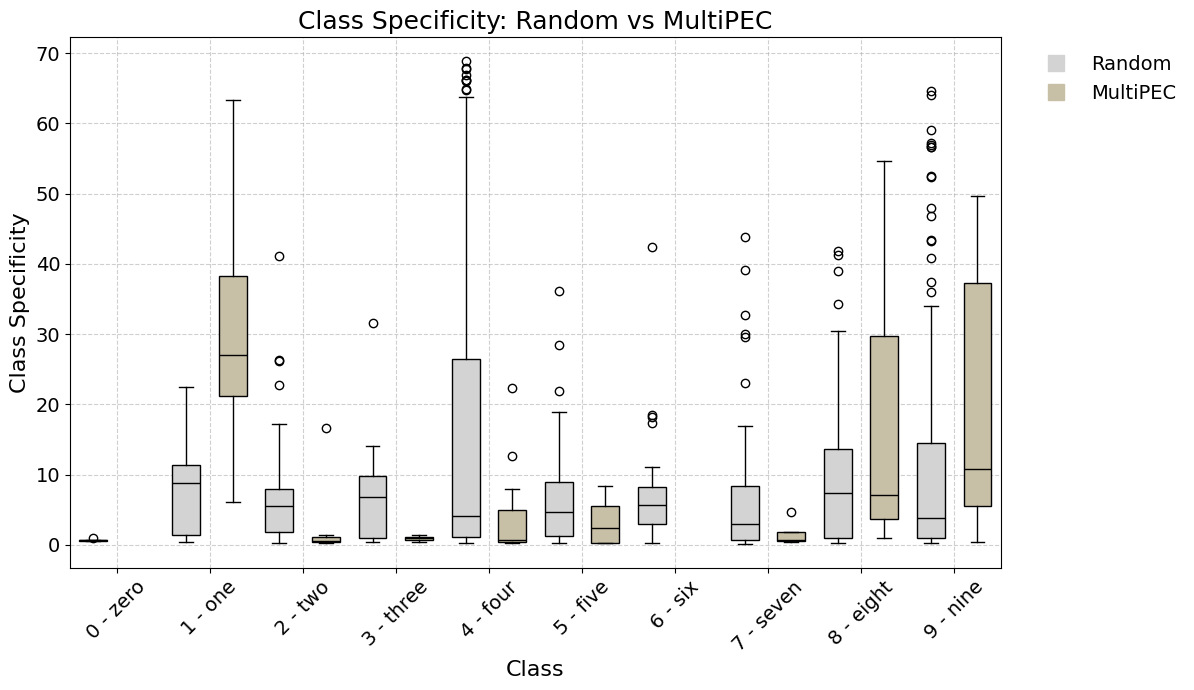

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import pandas as pd

detailed_df = pd.read_excel(os.path.join(RESULTS_FOLDER, "global_random_pruning_log.xlsx"))
pec_df = pd.read_excel(RESULTS_FOLDER+"pec_class_specificity_data.xlsx")

# Define class order explicitly
ordered_classes = [
    "0 - zero", "1 - one", "2 - two", "3 - three", "4 - four",
    "5 - five", "6 - six", "7 - seven", "8 - eight", "9 - nine"
]

# Filter classes that are present in the dataset
class_order = [cls for cls in ordered_classes if cls in detailed_df['Specific_Class'].unique()]

plt.figure(figsize=(12, 7))

# Prepare data for boxplots
random_data = [
    detailed_df[detailed_df['Specific_Class'] == cls]['Specificity'].values
    for cls in class_order
]
pec_data = [
    pec_df[pec_df['Class'] == cls]['MaxMean'].values
    for cls in class_order
]

# Define positions
positions_random = [i * 2 + 1 for i in range(len(class_order))]
positions_pec = [i * 2 + 2 for i in range(len(class_order))]

# Plot random pruning boxplots (gray)
box_random = plt.boxplot(
    random_data,
    positions=positions_random,
    widths=0.6,
    patch_artist=True
)
for patch in box_random['boxes']:
    patch.set_facecolor('#d3d3d3')  # light gray
for median in box_random['medians']:
    median.set_color('black')

# Plot PEC pruning as boxplots (neutral color), though they are single values
box_pec = plt.boxplot(
    pec_data,
    positions=positions_pec,
    widths=0.6,
    patch_artist=True
)
for patch in box_pec['boxes']:
    patch.set_facecolor('#c8bfa7')  # neutral beige tone
for median in box_pec['medians']:
    median.set_color('black')

# X-axis labels centered between paired plots
xtick_positions = [(r + p) / 2 for r, p in zip(positions_random, positions_pec)]
plt.xticks(xtick_positions, class_order, rotation=45, fontsize=14)

# Custom legend
gray_patch = mlines.Line2D([], [], color='#d3d3d3', marker='s', linestyle='None',
                           markersize=12, label='Random')
neutral_patch = mlines.Line2D([], [], color='#c8bfa7', marker='s', linestyle='None',
                              markersize=12, label='MultiPEC')
plt.legend(
    handles=[gray_patch, neutral_patch],
    fontsize=14,
    loc='upper left',
    bbox_to_anchor=(1.02, 1),
    frameon=False
)

# Labels and formatting
plt.xlabel('Class', fontsize=16)
plt.ylabel('Class Specificity', fontsize=16)
plt.title('Class Specificity: Random vs MultiPEC', fontsize=18)

plt.yticks(fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.subplots_adjust(left=0.3)
plt.tight_layout()
plt.show()


Check statistical differences between class specificity distributions of random and MultiPEC networks. 

In [ ]:
import numpy as np
from scipy.stats import shapiro, mannwhitneyu, ttest_ind, levene
import seaborn as sns

sns.set_style("whitegrid")

detailed_df = pd.read_excel(os.path.join(RESULTS_FOLDER, "global_random_pruning_log.xlsx"))
pec_df = pd.read_excel(os.path.join(RESULTS_FOLDER, "pec_class_specificity_data.xlsx"))

ordered_classes = [
    "0 - zero", "1 - one", "2 - two", "3 - three", "4 - four",
    "5 - five", "6 - six", "7 - seven", "8 - eight", "9 - nine"
]
class_order = [cls for cls in ordered_classes if cls in detailed_df['Specific_Class'].unique()]

random_all = pd.concat([
    pd.Series(detailed_df[detailed_df['Specific_Class'] == cls]['Specificity'].values)
    for cls in class_order
])
pec_all = pd.concat([
    pd.Series(pec_df[pec_df['Class'] == cls]['MaxMean'].values)
    for cls in class_order
])

shapiro_random = stats.shapiro(random_all.sample(500, random_state=0)) if len(random_all) > 500 else stats.shapiro(random_all)
shapiro_pec = stats.shapiro(pec_all)

print("Shapiro-Wilk Random:", shapiro_random)
print("Shapiro-Wilk MultiPEC:", shapiro_pec)

if shapiro_random.pvalue > 0.05 and shapiro_pec.pvalue > 0.05:
    test_res = stats.ttest_ind(random_all, pec_all, equal_var=False)  # Welch’s t-test
    test_name = "Welch t-test"
else:
    test_res = stats.mannwhitneyu(random_all, pec_all, alternative='two-sided')
    test_name = "Mann–Whitney U"

print(f"{test_name}: statistic={test_res.statistic:.4f}, p-value={test_res.pvalue:.4e}")

Visualize overall kernel density estimate of class specificity scores for random and MultiPEC networks.

/tmp/ipython-input-2896273515.py:3: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(random_all, color='#d3d3d3', fill=True, alpha=0.9, label='Random', vertical=True)
/tmp/ipython-input-2896273515.py:4: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(pec_all, color='#c8bfa7', fill=True, alpha=0.6, label='MultiPEC', vertical=True)


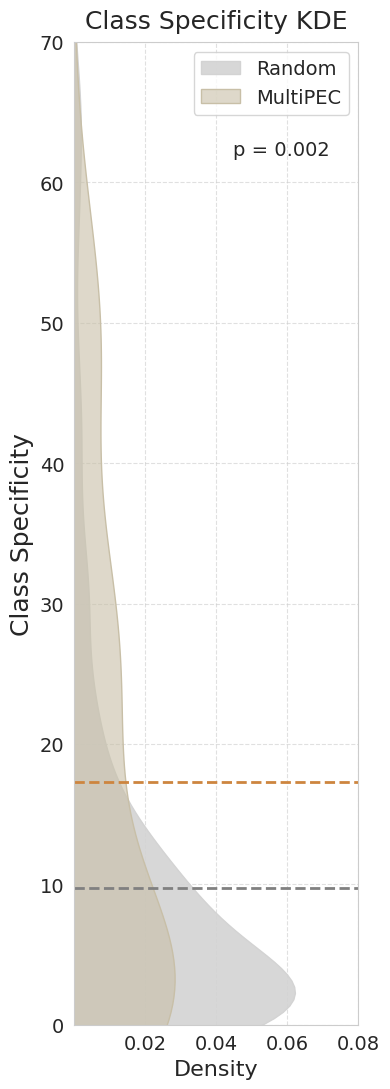

In [ ]:
plt.figure(figsize=(4, 11))

ax = sns.kdeplot(random_all, color='#d3d3d3', fill=True, alpha=0.9, label='Random', vertical=True)
sns.kdeplot(pec_all, color='#c8bfa7', fill=True, alpha=0.6, label='MultiPEC', vertical=True)

ax.set_ylim(0, 70)  # swap to y-limit for vertical KDE

# Add mean lines (horizontal now)
plt.axhline(np.mean(random_all), color='gray', linestyle='--', linewidth=2)
plt.axhline(np.mean(pec_all), color='peru', linestyle='--', linewidth=2)

plt.ylabel('Class Specificity', fontsize=18)
plt.xlabel('Density', fontsize=16)
plt.title('Class Specificity KDE', fontsize=18, pad=10)

# Add significance annotation (adjust x,y for vertical)
x_pos = plt.gca().get_xlim()[1] * 1.1  # near right edge of x-axis (density axis)
y_pos = max(random_all.max(), pec_all.max()) * 0.9

plt.text(x_pos, y_pos, f'p = {test_res.pvalue:.3f}', fontsize=14, ha='right')

plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
ax = plt.gca()

# Remove zero tick from x-axis (density axis)
xticks = ax.get_xticks()
xticks = xticks[xticks != 0]
ax.set_xticks(xticks)

plt.legend(fontsize=14, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_FOLDER, "Random_vs_PEC_kde.png"),
            bbox_inches='tight', dpi=300)
plt.show()


Visualize the kernel density estimates per class, and print the number of data points for each distribution.

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


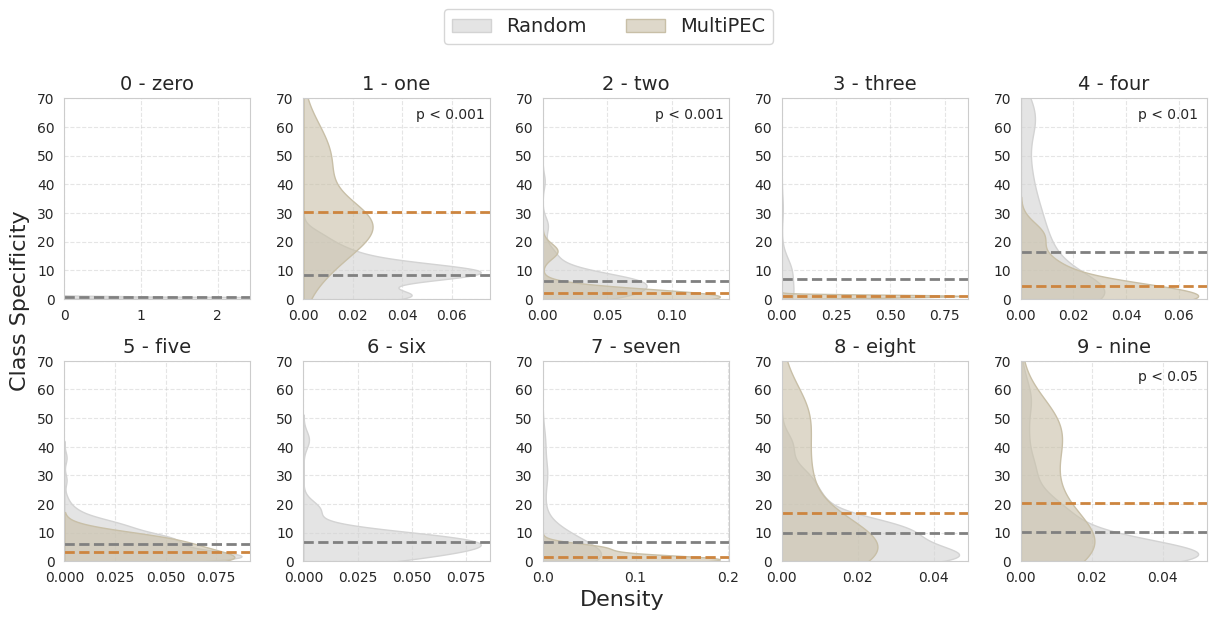

Class '0 - zero': Random data points = 5, MultiPEC data points = 0
Class '1 - one': Random data points = 59, MultiPEC data points = 36
Class '2 - two': Random data points = 94, MultiPEC data points = 13
Class '3 - three': Random data points = 20, MultiPEC data points = 4
Class '4 - four': Random data points = 206, MultiPEC data points = 11
Class '5 - five': Random data points = 184, MultiPEC data points = 4
Class '6 - six': Random data points = 54, MultiPEC data points = 0
Class '7 - seven': Random data points = 59, MultiPEC data points = 4
Class '8 - eight': Random data points = 110, MultiPEC data points = 22
Class '9 - nine': Random data points = 209, MultiPEC data points = 19


In [ ]:
# Load data
detailed_df = pd.read_excel(os.path.join(RESULTS_FOLDER, "global_random_pruning_log.xlsx"))
pec_df = pd.read_excel(os.path.join(RESULTS_FOLDER, "pec_class_specificity_data.xlsx"))

# Define class order
ordered_classes = [
    "0 - zero", "1 - one", "2 - two", "3 - three", "4 - four",
    "5 - five", "6 - six", "7 - seven", "8 - eight", "9 - nine"
]
class_order = [cls for cls in ordered_classes if cls in detailed_df['Specific_Class'].unique()]

# Create subplots (2 rows x 5 columns for 10 classes)
fig, axes = plt.subplots(2, 5, figsize=(12, 6), sharey=False)
axes = axes.flatten()

for i, cls in enumerate(class_order):
    ax = axes[i]

    # Get data
    random_vals = detailed_df[detailed_df['Specific_Class'] == cls]['Specificity'].values
    pec_vals = pec_df[pec_df['Class'] == cls]['MaxMean'].values

    # Plot smoothed KDEs vertically
    sns.kdeplot(y=random_vals, color='#d3d3d3', fill=True, alpha=0.6, ax=ax, label='Random')
    sns.kdeplot(y=pec_vals, color='#c8bfa7', fill=True, alpha=0.6, ax=ax, label='MultiPEC')

    # Add mean lines (horizontal now)
    ax.axhline(np.mean(random_vals), color='gray', linestyle='--', linewidth=2)
    ax.axhline(np.mean(pec_vals), color='peru', linestyle='--', linewidth=2)

    ax.set_title(cls, fontsize=14)
    ax.grid(True, linestyle="--", alpha=0.5)

    ax.set_ylim(0, 70)  # Specificity now on y-axis

    # Remove individual axis labels and ticks
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(axis='x', which='both', bottom=False, top=False)
    ax.tick_params(axis='y', which='both', left=False, right=False)

    # ---- Statistical testing ----
    if len(pec_vals) == 0:
        continue

    p_random = shapiro(random_vals)[1]
    p_pec = shapiro(pec_vals)[1]
    normal_random = p_random > 0.05
    normal_pec = p_pec > 0.05

    if normal_random and normal_pec:
        equal_var = levene(random_vals, pec_vals)[1] > 0.05
        stat, pval = ttest_ind(random_vals, pec_vals, equal_var=equal_var)
    else:
        stat, pval = mannwhitneyu(random_vals, pec_vals, alternative='two-sided')

    if pval < 0.001:
        signif = 'p < 0.001'
    elif pval < 0.01:
        signif = 'p < 0.01'
    elif pval < 0.05:
        signif = 'p < 0.05'
    else:
        signif = ''

    ax.text(0.79, 0.9, signif, transform=ax.transAxes, fontsize=10,
            bbox=dict(facecolor='white', alpha=0.0), ha='center')

# Common legend
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, fontsize=14, loc='upper center', ncol=2)

# Common axis labels
fig.text(0.5, -0.01, 'Density', ha='center', fontsize=16)
fig.text(-0.01, 0.5, 'Class Specificity', va='center', rotation='vertical', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.savefig(os.path.join(FIGURES_FOLDER, "Random_vs_PEC_kde_with_stats.png"),
            bbox_inches='tight', dpi=300)
plt.show()

for cls in class_order:
    random_vals = detailed_df[detailed_df['Specific_Class'] == cls]['Specificity'].values
    pec_vals = pec_df[pec_df['Class'] == cls]['MaxMean'].values
    print(f"Class '{cls}': Random data points = {len(random_vals)}, MultiPEC data points = {len(pec_vals)}")
